In [7]:
from loadmodules import *
import numpy as np
import os
from skimage.feature import peak_local_max
from skimage import io, color

path = '/home/pdcg/SimsOutput/'
simulation_list = [directory for directory in os.listdir(path) if 'lvl4' in directory]

In [8]:
simulation_list

['Au6_lvl4_6c8f']

In [9]:
snap = 127
outputdir = path+simulation_list[0]+'/output/'
"""Load a subfind catalogue for a given snapshot"""
sf = load_subfind( snap, dir=outputdir, hdf5=True, loadonly=['fpos', 'frc2', 'svel', 'flty', 'fnsh', 'slty', 'spos', 'smty', 'ffsh'] )

"""Then load various attributes of star+wind particles from snapshot"""
partType = 4
attrstoload = ['pos', 'vel', 'mass', 'age', 'bpos', 'bvel', 'bdens', 'gima', 'gsph', 'id', 'pot', 'nclt']
snapbase="snapshot_"
snapdirbase="snapdir_"

s = gadget_readsnap( snap, snappath=outputdir, snapbase=snapbase, snapdirbase=snapdirbase, hdf5=True, loadonlytype=[4], loadonly=attrstoload, subfind=sf )

/home/pdcg/pylib/gadget_snap.py:730: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


In [10]:
"""Set up halo/subhalo indices in the gadget_readsnap.data struct"""
s.calc_sf_indizes( sf )
"""Then select main halo, centre and rotate."""
s.select_halo( sf, use_principal_axis=True, use_cold_gas_spin=False, do_rotation=True )

galrad= 0.021277722716331483
Found 1348605 stars.
Rotated pos.
Rotated vel.


array([[-0.01912785,  0.45846162,  0.88850834],
       [ 0.69639134, -0.6315465 ,  0.34086377],
       [ 0.71740729,  0.62526951, -0.30718857]])

In [11]:
s.cosmology_get_lookback_time_from_a(0.9656, is_flat=True)

0.5012599558355166

In [39]:
s.cosmology_get_lookback_time_from_a(0.7, is_flat=True)

4.650954730654922

In [63]:
boxsize = 0.05
dist = np.max( np.abs( s.pos - s.center[None,:] ), axis=1 )
numthreads = 8
res = 1024
xres = res
yres = res

proj = np.zeros( (2,xres,yres,3) )
for i in range(2):
    if i==0:
        istars, = np.where( (s.type == 4) & (dist < 1.5*boxsize) & (s.data['age'] > 0.) )
    else:
        istars, = np.where( (s.type == 4) & (dist < 1.5*boxsize) & (s.data['age'] > 0.) & (s.data['age'] > 0.95) & (s.data['nclt'] > 0) )

    pos_orig = s.pos[istars].astype('f8')
    mass = s.data['mass'][istars].astype('f8')

    particle_oct_tree = makeTree( pos_orig )
    hsml = particle_oct_tree.calcHsmlMulti( pos_orig, pos_orig, mass, 48, numthreads=numthreads )
    hsml = np.minimum( hsml, 4. * boxsize / res )
    hsml = np.maximum( hsml, 1.001 * boxsize / res * 0.5 )

    rho = np.ones( np.size(mass) )

    datarange = np.array( [ [4003.36,800672.], [199.370,132913.], [133.698,200548.] ] ) # ranges for each colour channel to make nice images ;)
    fac = (512./res)**2 * (0.5 * boxsize / 0.025)**2 # Normalised pixel area 
    datarange *= fac

    pos = np.zeros( (size(istars),3) )
    pos[:,0] = pos_orig[:,1]
    pos[:,1] = pos_orig[:,2]
    pos[:,2] = pos_orig[:,0]

    boxx = boxsize
    boxy = boxsize

    """Import requried C routines"""
    import calcGrid 

    boxz = max( boxx, boxy )

    for k in range(3):
        iband = [3,1,0][k]
        band = 10 ** ( -2.0 * s.data['gsph'][istars,iband] / 5.0 )

        grid = calcGrid.calcGrid( pos, hsml, band.astype('f8'), rho, rho, xres, yres, 256, boxx, boxy, boxz, 
                                0., 0., 0., 1, 1, numthreads=numthreads )

        drange = datarange[k]
        grid = np.minimum( np.maximum( grid, drange[0] ), drange[1] )
        loggrid = np.log10( grid )
        logdrange = np.log10( drange )

        proj[i,:,:,k] = (loggrid - logdrange[0]) / (logdrange[1] - logdrange[0])

Creating tree for 1472135 particles with 4416405 nodes.
Domainlen: 0.157492
Tree creation took 0.714138s
Doing 1472135 positions with 8 thread(s).
No hsmlGuess found.
14724 / 1472135 particles done (1%): 0s elapsed, ~5s remaining
147221 / 1472135 particles done (10%): 0s elapsed, ~8s remaining
294431 / 1472135 particles done (20%): 2s elapsed, ~8s remaining
441642 / 1472135 particles done (30%): 3s elapsed, ~7s remaining
588853 / 1472135 particles done (39%): 4s elapsed, ~7s remaining
736066 / 1472135 particles done (49%): 5s elapsed, ~5s remaining
883286 / 1472135 particles done (60%): 7s elapsed, ~4s remaining
1030492 / 1472135 particles done (69%): 8s elapsed, ~3s remaining
1177708 / 1472135 particles done (80%): 10s elapsed, ~2s remaining
1324918 / 1472135 particles done (89%): 11s elapsed, ~1s remaining
1472134 / 1472135 particles done (99%): 12s elapsed, ~0s remaining
Hsml calculation took 12.47s
Creating tree for 52 particles with 156 nodes.
Domainlen: 0.0547551
Tree creation to

In [64]:
%matplotlib inline

In [69]:
gray = color.rgb2gray(10*proj[1])
coordinates = peak_local_max(gray, min_distance=15, threshold_abs=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(50, 50, 'Age < 0.5 Gyr')

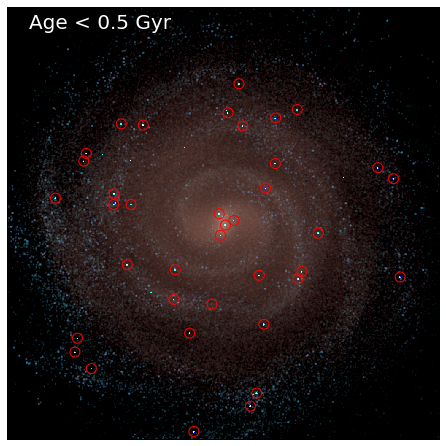

In [70]:
plt.figure( figsize=(6,6) )
ax1 = axes( [0., 0., 1., 1.] )
# ax1.set_xlim(400, 600)
# ax1.set_ylim(400, 600)
ax1.set_xticks( [] )
ax1.set_yticks( [] )
ax1.imshow( 0.6*proj[0] + 1e3*proj[1], interpolation='nearest' )
ax1.scatter( coordinates[:,1], coordinates[:,0], s=100, marker='o', edgecolors='r', facecolors='none')
ax1.text(50,50, 'Age < 0.5 Gyr', color='white', fontsize=20)

In [67]:
print("Bright points found at:", coordinates)

Bright points found at: [[ 280  322]
 [ 946  576]
 [1006  442]
 [ 640  931]
 [ 752  608]
 [ 443  253]
 [ 517  517]
 [ 536  737]
 [ 915  591]
 [ 182  549]
 [ 468  293]
 [ 381  878]
 [ 282  558]
 [ 243  687]
 [ 407  915]
 [ 627  698]
 [ 818  160]
 [ 611  284]
 [ 365  181]
 [ 263  636]
 [ 644  689]
 [ 468  252]
 [ 453  114]
 [ 429  612]
 [ 371  635]
 [ 490  502]
 [ 623  398]
 [ 785  166]
 [ 347  187]
 [ 704  485]
 [ 636  597]
 [ 251  523]
 [ 277  270]
 [ 857  199]
 [ 506  537]
 [ 541  505]
 [ 773  432]
 [ 693  395]]


In [10]:
import pynbody
import numpy as np
import matplotlib.pyplot as plt

In [11]:
s = pynbody.load(path+simulation_list[0]+'/output/snapdir_127/snapshot_127')
h = s.halos()

/home/pdcg/.local/lib/python3.10/site-packages/pynbody/snapshot/gadgethdf.py:403: UserWarning: Masses are either stored in the header or have another dataset name; assuming the cosmological factor h**-1
  warnings.warn("Masses are either stored in the header or have another dataset name; assuming the cosmological factor %s" % units.h**-1)


In [12]:
transform = pynbody.analysis.angmom.faceon(h[0])
s.physical_units()

In [13]:
main = h[0]

In [14]:
%matplotlib inline

In [15]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)

/tmp/ipykernel_42498/990634569.py:1: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)


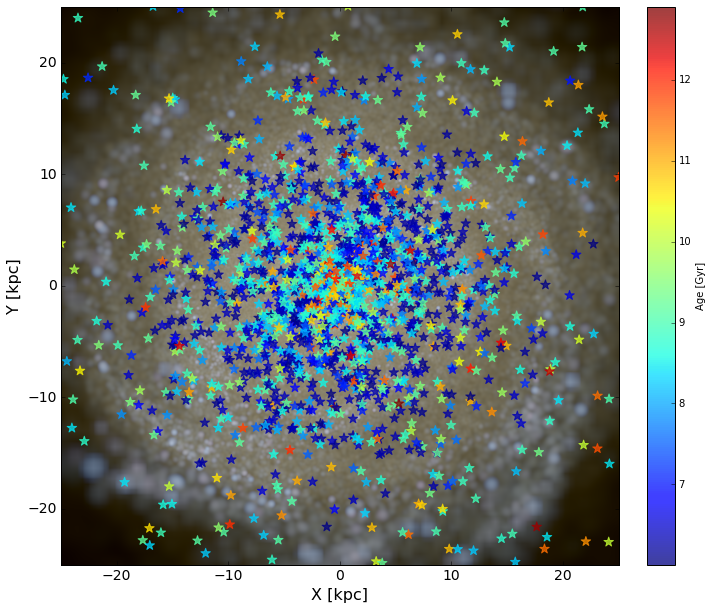

In [17]:
fig, ax1 = plt.subplots(figsize=(10,10))

mask1 = (main.s['NumberOfClusters']>0) * (main.s['age'].in_units('Gyr') > 6)# * (np.abs(main.s['z'])<2)
with pynbody.analysis.faceon(h[0]):
    pynbody.plot.stars.render(main,width=60,resolution=1000, mag_range=[18, 30], axes=ax1, dynamic_range=4, clear=False)
sc = ax1.scatter(main.s['pos'][mask1,0], main.s['pos'][mask1,1], marker = '*', c=main.s['age'].in_units('Gyr')[mask1], edgecolors='face', s=100, alpha=0.75)
ax1.set(xlim=(-25,25), ylim=(-25,25))
# ax1.text(10,25,r'z=0, $\tau_{\rm{cl}} < 500$ Myr', fontsize=16, color='w')
ax1.tick_params(axis='both', which='both', labelsize=14)
ax1.set_xlabel('X [kpc]', fontsize=16)
ax1.set_ylabel('Y [kpc]', fontsize=16)
plt.colorbar(sc, label='Age [Gyr]', cax=ax1.inset_axes([1.05, 0., 0.05, 1.]))

# ax2 = plt.axes([0,0,1,1])
# ip = InsetPosition(ax1, [0.5, 0.03, 0.48, 0.48])
# ax2.set_axes_locator(ip)
# mark_inset( ax1, ax2, loc1=1, loc2=3, fc="none", ec="w")
# pynbody.plot.stars.render(main,width=6,resolution=1000, mag_range=[18, 25], axes=ax2, dynamic_range=4, clear=False)
# mask2 = (main.s['NumberOfClusters']>0) * (main.s['age'].in_units('Gyr') < 0.1) * (np.abs(main.s['pos'][:,0])<4) * (np.abs(main.s['pos'][:,1])<4)# * (np.abs(main.s['z'])<2)
# ax2.scatter(main.s['pos'][mask2,0], main.s['pos'][mask2,1], marker = 'o', facecolor='none', edgecolors='m', s=300)
# ax2.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
# for spine in ax2.spines.values():
#     spine.set_edgecolor('w')
# ax2.set(xlabel='', ylabel='', xlim=(-3,3), ylim=(-3,3))

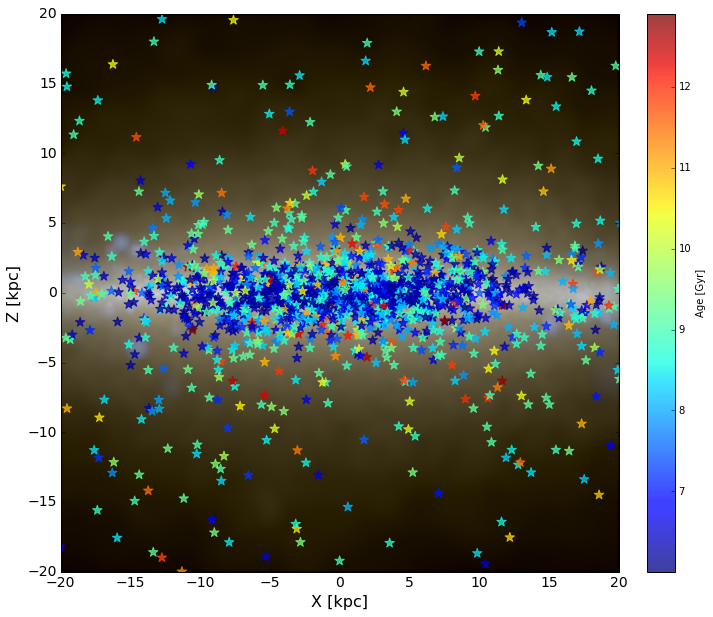

In [19]:
fig, ax1 = plt.subplots(figsize=(10,10))

with pynbody.analysis.sideon(h[0]):
    pynbody.plot.stars.render(main,width=40,resolution=1000, mag_range=[18, 30], axes=ax1, dynamic_range=4, clear=False)
sc = ax1.scatter(main.s['pos'][mask1,1], main.s['pos'][mask1,2], marker = '*', c=main.s['age'].in_units('Gyr')[mask1], edgecolors='face', s=100, alpha=0.75)
ax1.set(xlim=(-20,20), ylim=(-20,20))
# ax1.text(10,25,r'z=0, $\tau_{\rm{cl}} < 500$ Myr', fontsize=16, color='w')
ax1.tick_params(axis='both', which='both', labelsize=14)
ax1.set_xlabel('X [kpc]', fontsize=16)
ax1.set_ylabel('Z [kpc]', fontsize=16)
plt.colorbar(sc, label='Age [Gyr]', cax=ax1.inset_axes([1.05, 0., 0.05, 1.]))
# plt.tight_layout()